#Notebook Overview — Regain → Progression Analysis Pipeline (Demo)

This notebook demonstrates a simplified version of the data-processing pipeline I built for match analysis projects.
It uses synthetic, anonymised event data and focuses on the logic behind:

-Cleaning and validating event-level datasets

-Normalising coordinates and game-time

-Detecting ball recovery actions (“regains”)

-Identifying subsequent forward/lateral progressions

-Linking regain → progression chains within a set time window

-Classifying thirds, corridors, and time segments

-Producing a structured output suitable for tactical insights and visualisation

-Creating an example heatmap showing progression density and direction


The goal of this demo is to give a clear view of how I structure football analysis workflows and create metrics , from raw event data to finally a visual ready for presentation.
While the notebook avoids any club-specific information, it reflects the same principles I applied during professional and academic analysis projects.


#  Table of Contents

1. **API Authentication & Setup**
2. **Load Match Iterations / Metadata**
3. **Retrieve Matchplan & Filter Last 4 Matches**
4. **Extract Matches by Known Match IDs (Anonymised)**
5. **Download Event Data for Each Team**
6. **Initial Data Validation (Columns, Ranges, Structure)**
7. **Inspect Coordinate & Time Encoding (Scaling, Ranges, Period Logic)**
8. **Regain → Progression Pipeline (Demo)**
9. **Pipeline Output Inspection & Validation**
10. **Top 3 Regain Players (Middle + Attacking Thirds)**
11. **Progression Density & Direction Heatmap (Demo)**


### 1. Authenticate and Retrieve Competition Metadata


In [ ]:
import impectPy as ip

# Re-authenticate if needed
token = ip.getAccessToken(username="", password="")

# Get football competition iterations
iterations = ip.getIterations(token=token)

### 2. Select and Export the Last Four Completed Matches per Team


In [ ]:
import pandas as pd
from datetime import datetime

# Convert scheduledDate to datetime
matchplan["scheduledDate"] = pd.to_datetime(matchplan["scheduledDate"])

# Make today's date timezone-aware (to match dataset format)
today = pd.Timestamp(datetime.today().date(), tz="UTC")

# Define anonymised team names
teams = {
    "teamA": "Team A",
    "teamB": "Team B"
}

# Filter and save last 4 completed matches per team
for key, team_name in teams.items():
    team_matches = (
        matchplan[
            (
                (matchplan["homeSquadName"] == team_name)
                | (matchplan["awaySquadName"] == team_name)
            )
            & (matchplan["scheduledDate"] < today)
        ]
        .sort_values("scheduledDate", ascending=False)
        .head(4)
    )

    team_matches.to_csv(f"{key}_last4_matches.csv", index=False)
    print(f"Saved last 4 completed matches for {team_name} → {key}_last4_matches.csv")


### 3. Load and Inspect the Last Four Matches (Anonymised)


In [ ]:
# ---------------------------------------------------------
#  Load and inspect the most recent matches for
#            multiple teams in a match-plan dataset.
#            (Anonymised version for demo use)
# ---------------------------------------------------------

import pandas as pd

# Anonymised team identifiers
teams = ["teamA", "teamB"]

# Load and inspect each team's last 4 matches
for team in teams:
    df = pd.read_csv(f"{team}_last4_matches.csv")

    print(f"\n🔍 {team.upper()} — Last 4 Completed Matches")

    # Show key scheduling and team information (anonymised)
    print(
        df[[
            "id",
            "scheduledDate",
            "homeTeamName",
            "awayTeamName"
        ]]
    )

    # Basic checks
    print("✅ Unique match IDs:", df["id"].nunique())
    print("📅 Latest match date:", pd.to_datetime(df["scheduledDate"]).max())


### 4. Filter Matches by Known Match IDs and Export (Anonymised)


In [ ]:
# ---------------------------------------------------------
#  Extract and save the last confirmed matches
#            for two teams based on known match IDs.
#            (Anonymised version for portfolio use)
# ---------------------------------------------------------

import pandas as pd

# Ensure match dates are parsed correctly
matchplan["scheduledDate"] = pd.to_datetime(matchplan["scheduledDate"])

# Anonymised match ID lists for two teams
teamA_match_ids = [1001, 1002, 1003, 1004]   # synthetic example IDs
teamB_match_ids = [2001, 2002, 2003, 2004]   # synthetic example IDs

# Filter matchplan for Team A
teamA_df = (
    matchplan[matchplan["id"].isin(teamA_match_ids)]
    .sort_values("scheduledDate", ascending=False)
)
teamA_df.to_csv("teamA_last4_matches.csv", index=False)
print("✅ Saved: teamA_last4_matches.csv")

# Filter matchplan for Team B
teamB_df = (
    matchplan[matchplan["id"].isin(teamB_match_ids)]
    .sort_values("scheduledDate", ascending=False)
)
teamB_df.to_csv("teamB_last4_matches.csv", index=False)
print("✅ Saved: teamB_last4_matches.csv")


### 5. Retrieve Event Data via API and Convert to DataFrames (Anonymised)


In [ ]:
# ---------------------------------------------------------
#  1. Import Required Libraries
# ---------------------------------------------------------
import impectPy as ip
import pandas as pd

# ---------------------------------------------------------
#  2. Authenticate with API (token omitted for security)
# ---------------------------------------------------------
token = ""   # Your token goes here (not shared in public repos)

# ---------------------------------------------------------
#  3. Define Match IDs for Each Team (Anonymised)
# ---------------------------------------------------------
teamA_match_ids = [1001, 1002, 1003, 1004]  # synthetic example IDs
teamB_match_ids = [2001, 2002, 2003, 2004]

# ---------------------------------------------------------
#  4. Retrieve Event Data for Each Team
# ---------------------------------------------------------
teamA_events = ip.getEvents(matches=teamA_match_ids, token=token)
teamB_events = ip.getEvents(matches=teamB_match_ids, token=token)

# ---------------------------------------------------------
#  5. Convert Results to DataFrames
# ---------------------------------------------------------
teamA_events_df = pd.DataFrame(teamA_events)
teamB_events_df = pd.DataFrame(teamB_events)

print("✅ Event data successfully loaded.")
print("📄 Team A dataframe shape:", teamA_events_df.shape)
print("📄 Team B dataframe shape:", teamB_events_df.shape)


### 6. Inspect Event Dataset Structure (Coordinates, Time, Teams)


In [ ]:
# 1️⃣ Check available coordinate columns
coord_cols = [
    c for c in events_df.columns
    if "x" in c.lower() or "y" in c.lower()
]
print("📍 Coordinate columns:", coord_cols)

# 2️⃣ Quick look at the first few rows of coordinates
print(events_df[coord_cols].head())

# 3️⃣ Check coordinate ranges
print("📊 Coordinate ranges:")
print(
    events_df[coord_cols]
    .describe()
    .T[["min", "max"]]
)

# 4️⃣ Verify if we have period / time fields
time_cols = [
    c for c in events_df.columns
    if "time" in c.lower()
    or "minute" in c.lower()
    or "period" in c.lower()
]
print("🕒 Time-related columns:", time_cols)
print(events_df[time_cols].head())

# 5️⃣ Verify if we have team / squad information
team_cols = [
    c for c in events_df.columns
    if "team" in c.lower()
    or "squad" in c.lower()
]
print("👕 Team columns:", team_cols)
print(events_df[team_cols].head())


### 7. Inspect Coordinate & Time Encoding (Scaling, Ranges, Period Logic)


In [ ]:
# ---------------------------------------------------------
# 1. Define Coordinate Columns for Inspection
# ---------------------------------------------------------
coord_cols = [
    "startCoordinatesX", "startCoordinatesY",
    "endCoordinatesX", "endCoordinatesY",
    "startAdjCoordinatesX", "startAdjCoordinatesY",
    "endAdjCoordinatesX", "endAdjCoordinatesY"
]

# ---------------------------------------------------------
#  2. Summarise Coordinate Ranges
# ---------------------------------------------------------
print("📍 Coordinate Range Summary:")

coord_summary = (
    events_df[coord_cols]
    .describe()
    .T[["min", "max"]]
    .sort_index()
)

print(coord_summary)

# ---------------------------------------------------------
#  3. Detect Coordinate Scaling (0–1, meters, or mixed)
# ---------------------------------------------------------
ranges = coord_summary["max"] - coord_summary["min"]

if (ranges < 2).all():
    print("\n⚠️ Coordinates appear normalized (0–1 scale).")
elif (ranges.max() > 100):
    print("\n📏 Coordinates likely represent meters (e.g., 105×68 pitch).")
else:
    print("\nℹ️ Mixed coordinate scaling — verify with metadata.")

# ---------------------------------------------------------
#  4. Inspect Time Encoding per Match Period
# ---------------------------------------------------------
time_cols = ["periodId", "gameTimeInSec"]

print("\n🕒 Time Summary by Period:")

if all(col in events_df.columns for col in time_cols):

    time_summary = (
        events_df.groupby("periodId")["gameTimeInSec"]
        .agg(["min", "max"])
        .reset_index()
        .sort_values("periodId")
    )

    print(time_summary)

    # Detect whether clocks reset or continue across periods
    if time_summary["min"].min() > 1000 or time_summary["max"].max() > 9000:
        print("\n⚠️ Time likely non-reset (continuous clock across halves).")
    else:
        print("\n✅ Time likely resets each half (0–2700 typical).")

else:
    print("⛔ Required time-related columns not found in the dataset.")


#8.Regain → Progression Pipeline (Demo)
This section shows an anonymised version of my regain-to-progression workflow:
the code normalises time and coordinates, tags thirds and corridors, detects ball regains, links them to the next progression within ≤5 seconds, flips directions into a team-centric frame, and exports clean datasets for analysis.

All data here is synthetic, but the pipeline structure reflects my real opposition analysis process.

In [ ]:
# ======================================================================
# ⚙️ TEAM A — REGAIN → PROGRESSION PIPELINE (ANONYMISED DEMO)
# ----------------------------------------------------------------------
# - Uses adjusted pitch coordinates (normalized centre = 0)
# - Handles non-reset clocks → normalised continuous timeline (0–5400s)
# - Produces direction-corrected datasets for “For” and “Against”
# - All identifiers, team names, match data are anonymised/synthetic
# ======================================================================

import pandas as pd
import numpy as np

TEAM = "Team A"   # anonymised team name

print("🚀 Starting Regain → Progression pipeline...\n")

# ----------------------------------------------------------------------
# 1️⃣ Load anonymised event data
# ----------------------------------------------------------------------
events_df = pd.read_csv("teamA_events_raw.csv")   # anonymised filename

# ----------------------------------------------------------------------
# 2️⃣ Structure & name standardisation
# ----------------------------------------------------------------------
events_df.columns = [c.strip() for c in events_df.columns]

required = [
    "matchId","teamName","playerName","actionType","gameTimeInSec",
    "startAdjCoordinatesX","startAdjCoordinatesY",
    "endAdjCoordinatesX","endAdjCoordinatesY","periodId"
]

missing = [c for c in required if c not in events_df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

events_df["teamName"] = events_df["teamName"].astype(str).str.strip()
print("✅ Structure OK and team names standardised.\n")

# ----------------------------------------------------------------------
# 3️⃣ Time normalisation (continuous 0–5400 seconds)
# ----------------------------------------------------------------------
print("🕒 Normalising gameTimeInSec across halves...")

period_bounds = (
    events_df.groupby(["matchId","periodId"])["gameTimeInSec"]
    .agg(["min","max"])
    .reset_index()
    .pivot(index="matchId", columns="periodId")
)
period_bounds.columns = [f"{p[1]}_{p[0]}" for p in period_bounds.columns]

def normalize_time(row):
    m, t, p = row["matchId"], row["gameTimeInSec"], row["periodId"]
    if p == 1:
        raw_min = period_bounds.loc[m,"1_min"]
        raw_max = period_bounds.loc[m,"1_max"]
        return ((t - raw_min) / (raw_max - raw_min)) * 2700
    elif p == 2:
        raw_min = period_bounds.loc[m,"2_min"]
        raw_max = period_bounds.loc[m,"2_max"]
        return 2700 + ((t - raw_min) / (raw_max - raw_min)) * 2700
    return np.nan

events_df["gameTimeInSec"] = events_df.apply(normalize_time, axis=1)
print("✅ Time scaled to continuous 0–5400s.\n")

# ----------------------------------------------------------------------
# 4️⃣ Coordinate normalisation
# ----------------------------------------------------------------------
for col_in, col_out in zip(
    ["startAdjCoordinatesX","endAdjCoordinatesX"], ["start_x","end_x"]
):
    events_df[col_out] = pd.to_numeric(events_df[col_in], errors="coerce")

for col_in, col_out in zip(
    ["startAdjCoordinatesY","endAdjCoordinatesY"], ["start_y","end_y"]
):
    events_df[col_out] = pd.to_numeric(events_df[col_in], errors="coerce")

x_min = events_df[["start_x","end_x"]].min().min()
x_max = events_df[["start_x","end_x"]].max().max()
MIDLINE = 0.0

print(f"📏 Detected pitch scale: {x_min:.1f} → {x_max:.1f}\n")

# ----------------------------------------------------------------------
# 5️⃣ Segment tagging (15-minute windows)
# ----------------------------------------------------------------------
def assign_segment(sec):
    if pd.isna(sec): return "Unknown"
    if sec < 900:   return "0–14"
    if sec < 1800:  return "15–29"
    if sec < 2700:  return "30–44"
    if sec < 3600:  return "45–59"
    if sec < 4500:  return "60–74"
    if sec <= 5700: return "75–90+"
    return np.nan

events_df["Segment"] = events_df["gameTimeInSec"].apply(assign_segment)
events_df = events_df[events_df["Segment"].notna()].copy()
print("✅ Segments assigned.\n")

# ----------------------------------------------------------------------
# 6️⃣ Thirds & corridors (generic 105×68 model, centred)
# ----------------------------------------------------------------------
def tag_third(x):
    if pd.isna(x): return np.nan
    if x < -17.5: return "Defensive Third"
    if x <= 17.5: return "Middle Third"
    return "Attacking Third"

def tag_corridor(y):
    if pd.isna(y): return np.nan
    if y < -20: return "Left Wide"
    if y < -7:  return "Left Half-space"
    if y <= 7:  return "Centre"
    if y <= 20: return "Right Half-space"
    return "Right Wide"

events_df["third_start"] = events_df["start_x"].apply(tag_third)
events_df["corridor_start"] = events_df["start_y"].apply(tag_corridor)
print("✅ Thirds & corridors tagged.\n")

# ----------------------------------------------------------------------
# 7️⃣ Regain detection (anonymised regain actions)
# ----------------------------------------------------------------------
regain_mask = events_df["actionType"].isin([
    "INTERCEPTION","DUEL_WIN","TACKLE","BLOCK",
    "LOOSE_BALL_WIN","SECOND_BALL","GK_CATCH"
])

regains = events_df[regain_mask].copy()
regains["Regain Player"] = regains["playerName"]
regains["Regain Type"]   = regains["actionType"]
regains["Regain X"]      = regains["start_x"]
regains["Regain Y"]      = regains["start_y"]

# ----------------------------------------------------------------------
# 8️⃣ Progression detection
# ----------------------------------------------------------------------
prog_mask = events_df["actionType"].isin(["PASS","DRIBBLE","CARRY","SHOT"])
progressions = events_df[prog_mask].copy()
progressions["dx"] = progressions["end_x"] - progressions["start_x"]

def tag_progression(row):
    a, dx = row["actionType"], row["dx"]
    if a == "SHOT": return "Shot"
    if a in ["DRIBBLE","CARRY"]:
        if dx > 0.5: return "Forward Carry"
        if dx < -0.5: return "Backward Carry"
        return "Lateral Carry"
    if a == "PASS":
        if dx > 0.5: return "Forward Pass"
        if dx < -0.5: return "Backward Pass"
        return "Lateral Pass"
    return np.nan

progressions["Progression Type"] = progressions.apply(tag_progression, axis=1)
progressions = progressions[progressions["Progression Type"].notna()].copy()

progressions["Progression Player"] = progressions["playerName"]
progressions["Progression X"]      = progressions["end_x"]
progressions["Progression Y"]      = progressions["end_y"]

# ----------------------------------------------------------------------
# 9️⃣ Link Regain → Progression (≤5 seconds)
# ----------------------------------------------------------------------
pairs = []

for _, rg in regains.iterrows():
    nxt = progressions[
        (progressions["matchId"] == rg["matchId"]) &
        (progressions["teamName"] == rg["teamName"]) &
        (progressions["gameTimeInSec"] > rg["gameTimeInSec"]) &
        (progressions["gameTimeInSec"] - rg["gameTimeInSec"] <= 5)
    ]
    if not nxt.empty:
        p = nxt.iloc[0]
        pairs.append({
            "matchId": rg["matchId"],
            "Team": rg["teamName"],
            "Regain Player": rg["Regain Player"],
            "Regain Type": rg["Regain Type"],
            "Regain X": rg["Regain X"],
            "Regain Y": rg["Regain Y"],
            "third_start": rg["third_start"],
            "corridor_start": rg["corridor_start"],
            "Progression Player": p["Progression Player"],
            "Progression Type": p["Progression Type"],
            "Progression X": p["Progression X"],
            "Progression Y": p["Progression Y"],
            "Segment": rg["Segment"],
            "Time Delta": p["gameTimeInSec"] - rg["gameTimeInSec"],
        })

regain_prog_df = pd.DataFrame(pairs)
print(f"🔗 Regain → Progression pairs built: {len(regain_prog_df)}\n")

# ----------------------------------------------------------------------
# 🔟 Split FOR vs AGAINST and apply team-centric orientation
# ----------------------------------------------------------------------
rp = regain_prog_df.copy()
rp["Team"] = rp["Team"].astype(str).str.strip()

team_for = rp[rp["Team"] == TEAM].copy()
team_against = rp[rp["Team"] != TEAM].copy()

print(f"✅ FOR: {len(team_for)} | AGAINST: {len(team_against)}\n")

# Flip X for “against”
for col in ["Regain X","Progression X"]:
    team_against[col] = -team_against[col]

team_against["third_start"] = team_against["Regain X"].apply(tag_third)
print("🔁 Opponent coordinates flipped.\n")

# ----------------------------------------------------------------------
# 11️⃣ Export anonymised CSV outputs
# ----------------------------------------------------------------------
cols = [
    "matchId","Team","Regain Player","Regain Type",
    "Regain X","Regain Y","third_start","corridor_start",
    "Progression Player","Progression Type",
    "Progression X","Progression Y",
    "Segment","Time Delta"
]

timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
for_path = f"teamA_regain_progression_for_{timestamp}.csv"
against_path = f"teamA_regain_progression_against_{timestamp}.csv"

team_for[cols].to_csv(for_path, index=False)
team_against[cols].to_csv(against_path, index=False)

print(f"💾 Files saved:\n - {for_path}\n - {against_path}\n")

# ----------------------------------------------------------------------
# 12️⃣ Summary
# ----------------------------------------------------------------------
print(f"⏱️ Mean Δt FOR: {team_for['Time Delta'].mean():.2f}s | "
      f"AGAINST: {team_against['Time Delta'].mean():.2f}s")
print("✅ Pipeline complete.\n")


#9.INSPECTION CODE BLOCK

In [ ]:
# ============================================================
# 🧪 POST-PIPELINE DATA QUALITY CHECK (ANONYMISED DEMO)
# ------------------------------------------------------------
# Ensures regain → progression outputs are complete, consistent,
# and ready for tactical visualisation and metric creation.
# ============================================================

import pandas as pd
from pathlib import Path

# ------------------------------------------------------------
# 1️⃣ Load latest exported files
# ------------------------------------------------------------
latest_for = sorted(Path(".").glob("teamA_regain_progression_for_*.csv"))[-1]
latest_against = sorted(Path(".").glob("teamA_regain_progression_against_*.csv"))[-1]

df_for = pd.read_csv(latest_for)
df_against = pd.read_csv(latest_against)

print(f"Loaded FOR file: {latest_for.name} → {df_for.shape}")
print(f"Loaded AGAINST file: {latest_against.name} → {df_against.shape}")

# ------------------------------------------------------------
# 2️⃣ Required column check
# ------------------------------------------------------------
required_cols = [
    "matchId","Team","Regain Player","Regain Type","Regain X","Regain Y",
    "third_start","corridor_start","Progression Player","Progression Type",
    "Progression X","Progression Y","Segment","Time Delta"
]

missing_for = [c for c in required_cols if c not in df_for.columns]
missing_against = [c for c in required_cols if c not in df_against.columns]

print("\nColumn completeness:")
print("FOR missing:", missing_for)
print("AGAINST missing:", missing_against)

# ------------------------------------------------------------
# 3️⃣ Basic coordinate + Δt sanity check
# ------------------------------------------------------------
def coord_summary(df):
    return pd.DataFrame({
        "Regain X (min)": df["Regain X"].min(),
        "Regain X (max)": df["Regain X"].max(),
        "Prog X (min)": df["Progression X"].min(),
        "Prog X (max)": df["Progression X"].max(),
        "Δt min": df["Time Delta"].min(),
        "Δt max": df["Time Delta"].max(),
    }, index=[0])

print("\nCoordinate & time checks:")
print("FOR:\n", coord_summary(df_for))
print("AGAINST:\n", coord_summary(df_against))

# ------------------------------------------------------------
# 4️⃣ Match coverage check
# ------------------------------------------------------------
print("\nMatch coverage:")
print("FOR:", df_for["matchId"].nunique(), "matches")
print("AGAINST:", df_against["matchId"].nunique(), "matches")

# ------------------------------------------------------------
# 5️⃣ Data completeness
# ------------------------------------------------------------
def completeness(df):
    total = df.size
    missing = df.isna().sum().sum()
    return 100 * (1 - missing / total)

print(f"\nData completeness: FOR={completeness(df_for):.1f}% | AGAINST={completeness(df_against):.1f}%")

# ------------------------------------------------------------
# 6️⃣ Final readiness flag
# ------------------------------------------------------------
criteria = [
    len(missing_for)==0,
    len(missing_against)==0,
    completeness(df_for) > 95,
    completeness(df_against) > 95,
]

ready = all(criteria)

print("\nAnalytical readiness:", "PASS" if ready else "CHECK REQUIRED")


#10.TOP 3 REGAIN PLAYERS

This section extracts a minimal dataset for visualisation, focusing on the players with the highest number of regains in advanced areas of the pitch.
The workflow filters regains occurring in the middle and attacking thirds, identifies the top three players by regain frequency, standardises column names, and exports a lightweight BI-ready CSV suitable for dashboards or match reports.
All data used is anonymised, while the structure reflects the reporting process applied in real opposition analysis work.

In [ ]:
# ======================================================================
# ⚙️ TOP 3 PLAYERS — MIDDLE + ATTACKING THIRDS ONLY (ANONYMISED DEMO)
# ----------------------------------------------------------------------
# Exports a minimal CSV for BI/dashboard use.
# Columns exported:
# matchId | Team | Regain Player | Regain Type | Regain_Third
# Regain_Corridor | Progression Player | Progression Type | Segment
# ======================================================================

import pandas as pd
from pathlib import Path

# ----------------------------------------------------------------------
# 1️⃣ Load the most recent processed dataset (teamA FOR)
# ----------------------------------------------------------------------
latest_for = sorted(Path(".").glob("teamA_regain_progression_for_*.csv"))[-1]
df_for = pd.read_csv(latest_for)

print(f"Loaded: {latest_for.name} ({df_for.shape[0]} rows)")

# ----------------------------------------------------------------------
# 2️⃣ Filter only Middle + Attacking Third regains
# ----------------------------------------------------------------------
filtered_df = df_for[df_for["third_start"].isin(["Middle Third", "Attacking Third"])].copy()
print(f"Filtered to Middle/Attacking Thirds: {filtered_df.shape[0]} rows")

# ----------------------------------------------------------------------
# 3️⃣ Identify top 3 players by regain count (within filtered subset)
# ----------------------------------------------------------------------
top3_players = (
    filtered_df["Regain Player"]
    .value_counts()
    .head(3)
    .index.tolist()
)

print("Top 3 regain players:", top3_players)

top3_df = filtered_df[filtered_df["Regain Player"].isin(top3_players)].copy()

# ----------------------------------------------------------------------
# 4️⃣ Rename columns for BI-friendly format
# ----------------------------------------------------------------------
top3_df.rename(columns={
    "third_start": "Regain_Third",
    "corridor_start": "Regain_Corridor",
}, inplace=True)

# ----------------------------------------------------------------------
# 5️⃣ Select minimal set of columns for export
# ----------------------------------------------------------------------
final_cols = [
    "matchId", "Team",
    "Regain Player", "Regain Type",
    "Regain_Third", "Regain_Corridor",
    "Progression Player", "Progression Type",
    "Segment"
]

top3_minimal = top3_df[final_cols].copy()

# ----------------------------------------------------------------------
# 6️⃣ Export BI-ready file
# ----------------------------------------------------------------------
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
output_path = f"teamA_regain_progression_top3_mid_att_minimal_{timestamp}.csv"

top3_minimal.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"\nSaved file: {output_path}")

# Optional preview
top3_minimal.head(10)


#11.Progression Demo Heatmap After Regains — Summary

This visual illustrates where the team progresses the ball after winning possession. The pitch is divided into thirds and corridors, and each zone is shaded based on the number of progressions ending there. Arrows indicate the average direction of play within each grid cell.

#What it shows

Spatial distribution of progressions following regains

Preferred attacking lanes (wide, half-spaces, central)

Directional tendencies immediately after possession recovery

#What insights can we get

This visual provides a clear spatial profile of how the team advances the ball after regains, supporting analysis of attacking behaviour, transition patterns, and tactical consistency across matches.

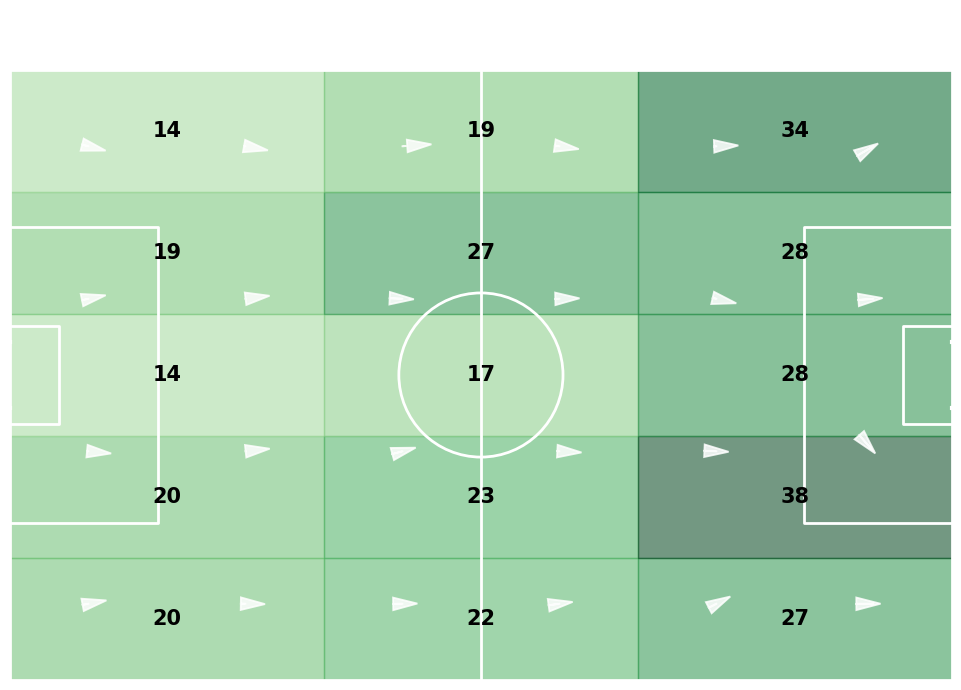

In [3]:
# --------------------------------------------------------------------------
#  Create a regain → progression heatmap using synthetic data.
#             Includes:
#             - Thirds & corridor binning
#             - Density shading
#             - Count labels
#             - Average direction arrows
#             - Full pitch drawing
#
#             This replicates the style of the original visual while
#             remaining fully anonymised and runnable.
# --------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ---------------------------------------------------------
# 1️⃣ Generate Synthetic Regain → Progression Data
# ---------------------------------------------------------
np.random.seed(7)
n = 350

reg_x = np.random.uniform(0, 105, n)
reg_y = np.random.uniform(0, 68, n)

prog_x = reg_x + np.random.normal(10, 12, n)
prog_y = reg_y + np.random.normal(0, 7, n)

prog_x = np.clip(prog_x, 0, 105)
prog_y = np.clip(prog_y, 0, 68)

df = pd.DataFrame({
    "regain_x": reg_x,
    "regain_y": reg_y,
    "progression_x": prog_x,
    "progression_y": prog_y
})

field_length, field_width = 105, 68

# ---------------------------------------------------------
# 2️⃣ Define Grid (Thirds × Corridors)
# ---------------------------------------------------------
x_bins = np.linspace(0, field_length, 4)
y_bins = np.linspace(0, field_width, 6)

counts, _, _ = np.histogram2d(
    df["progression_x"],
    df["progression_y"],
    bins=[x_bins, y_bins]
)

norm = mcolors.Normalize(vmin=0, vmax=max(1, counts.max()))
green_cmap = plt.cm.Greens
red_cmap   = plt.cm.Reds

# ---------------------------------------------------------
# 3️⃣ Set Up Pitch Canvas
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_xlim(0, field_length)
ax.set_ylim(0, field_width)
ax.set_aspect("equal")
ax.axis("off")
ax.patch.set_facecolor("#228B22")

# Pitch outline + halfway line
ax.plot([0,105,105,0,0],[0,0,68,68,0],color="white",lw=2)
ax.plot([52.5,52.5],[0,68],color="white",lw=2)

# ---------------------------------------------------------
# 4️⃣ Density Shading + Count Labels
# ---------------------------------------------------------
for i in range(len(x_bins) - 1):
    for j in range(len(y_bins) - 1):
        c = counts[i, j]

        # Light shading in empty defensive-third squares
        if i == 0 and c == 0:
            ax.add_patch(plt.Rectangle(
                (x_bins[i], y_bins[j]),
                x_bins[i+1]-x_bins[i], y_bins[j+1]-y_bins[j],
                color="#bfe8bf", alpha=0.25
            ))
            continue

        if c > 0:
            rect = plt.Rectangle(
                (x_bins[i], y_bins[j]),
                x_bins[i+1]-x_bins[i], y_bins[j+1]-y_bins[j],
                color=green_cmap(norm(c)), alpha=0.55
            )
            ax.add_patch(rect)

            cx = (x_bins[i] + x_bins[i+1]) / 2
            cy = (y_bins[j] + y_bins[j+1]) / 2

            ax.text(
                cx, cy, int(c),
                ha="center", va="center",
                fontsize=15, fontweight="bold",
                color="black"
            )

# ---------------------------------------------------------
# 5️⃣ Direction Arrows (Average Progression per Zone)
# ---------------------------------------------------------
x_bins_dir = np.linspace(0, field_length, 7)
y_bins_dir = np.linspace(0, field_width, 5)

for i in range(len(x_bins_dir)-1):
    for j in range(len(y_bins_dir)-1):
        cell = df[
            df["regain_x"].between(x_bins_dir[i], x_bins_dir[i+1]) &
            df["regain_y"].between(y_bins_dir[j], y_bins_dir[j+1])
        ]
        if len(cell) < 3:
            continue

        dx = (cell["progression_x"] - cell["regain_x"]).mean()
        dy = (cell["progression_y"] - cell["regain_y"]).mean()

        sx = (x_bins_dir[i] + x_bins_dir[i+1]) / 2
        sy = (y_bins_dir[j] + y_bins_dir[j+1]) / 2

        ax.arrow(
            sx, sy, dx*0.20, dy*0.20,
            head_width=1.4, head_length=2.7,
            color="white", alpha=0.85,
            linewidth=1.3, length_includes_head=True
        )

# ---------------------------------------------------------
# 6️⃣ Add Boxes & Goals
# ---------------------------------------------------------
# Centre circle
circle = plt.Circle((52.5, 34), 9.15, color="white", fill=False, lw=2)
ax.add_patch(circle)

# Penalty & goal boxes
# (same dimensions as your original)
for side in ["left","right"]:
    if side == "left":
        x0 = 0
        penalty_x = [0,16.5,16.5,0]
        goal_x = [0,5.5,5.5,0]
        goal_posts = [-2, 0]
    else:
        x0 = 105
        penalty_x = [105, 105-16.5, 105-16.5, 105]
        goal_x = [105, 105-5.5, 105-5.5, 105]
        goal_posts = [105, 107]

    # Penalty box
    ax.plot(penalty_x,
            [34-16.5,34-16.5,34+16.5,34+16.5],
            color="white", lw=2)

    # Goal box
    ax.plot(goal_x,
            [34-5.5,34-5.5,34+5.5,34+5.5],
            color="white", lw=2)

    # Goal posts
    ax.plot(goal_posts, [34-3.66,34-3.66], color="white", lw=3)
    ax.plot(goal_posts, [34+3.66,34+3.66], color="white", lw=3)

# ---------------------------------------------------------
# 7️⃣ Title
# ---------------------------------------------------------
ax.set_title(
    "Regain → Progression Heatmap (Synthetic Demo)\nDensity + Direction",
    fontsize=16, color="white", pad=15
)

plt.tight_layout()
plt.show()
